C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=1.0401, Train Acc=0.6168 | Val Loss=0.9359, Val Acc=0.6400
Epoch 2: Train Loss=0.8936, Train Acc=0.6627 | Val Loss=0.8191, Val Acc=0.6982
Epoch 3: Train Loss=0.8595, Train Acc=0.6700 | Val Loss=0.7826, Val Acc=0.7127
Epoch 4: Train Loss=0.8162, Train Acc=0.6841 | Val Loss=0.7646, Val Acc=0.7091
Epoch 5: Train Loss=0.7807, Train Acc=0.6995 | Val Loss=0.7362, Val Acc=0.7164
Epoch 6: Train Loss=0.7364, Train Acc=0.7141 | Val Loss=0.7118, Val Acc=0.7218
Epoch 7: Train Loss=0.7072, Train Acc=0.7245 | Val Loss=0.7078, Val Acc=0.7545
Epoch 8: Train Loss=0.7089, Train Acc=0.7350 | Val Loss=0.6941, Val Acc=0.7455
Epoch 9: Train Loss=0.6759, Train Acc=0.7314 | Val Loss=0.7124, Val Acc=0.7218
Epoch 10: Train Loss=0.6677, Train Acc=0.7455 | Val Loss=0.6959, Val Acc=0.7291
Epoch 11: Train Loss=0.6462, Train Acc=0.7482 | Val Loss=0.6694, Val Acc=0.7309
Epoch 12: Train Loss=0.6360, Train Acc=0.7564 | Val Loss=0.6782, Val Acc=0.7345
Epoch 13: Train Loss=0.6318, Train Acc=0.7550 | V

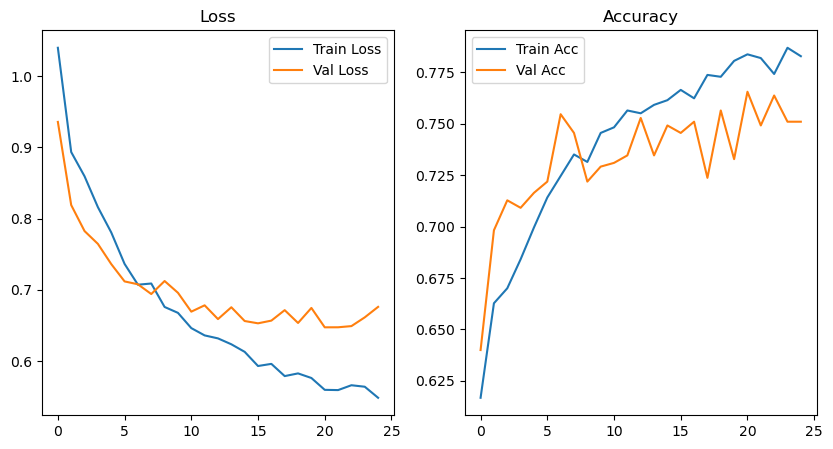


Classification Report:
                precision    recall  f1-score   support

       Healthy       0.93      0.96      0.95       192
       Mild DR       0.62      0.62      0.62        81
   Moderate DR       0.67      0.78      0.72       181
Proliferate DR       0.52      0.29      0.37        58
     Severe DR       0.40      0.26      0.32        38

      accuracy                           0.73       550
     macro avg       0.63      0.58      0.60       550
  weighted avg       0.72      0.73      0.72       550



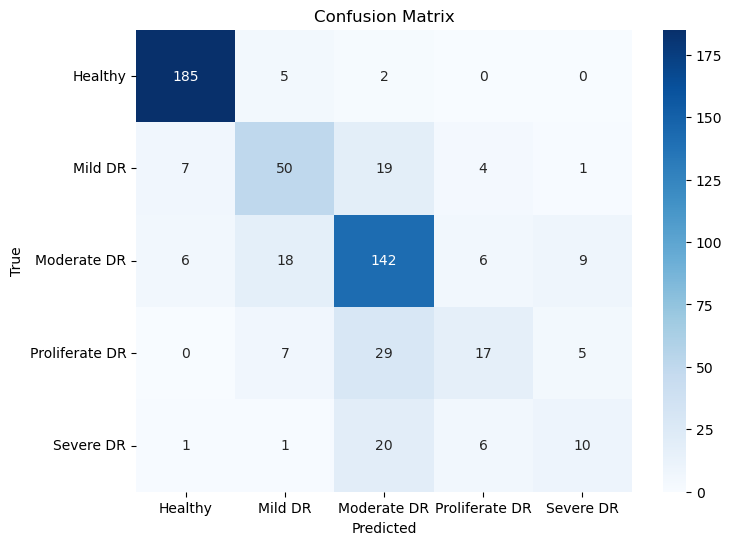

Predicted Class: Severe DR


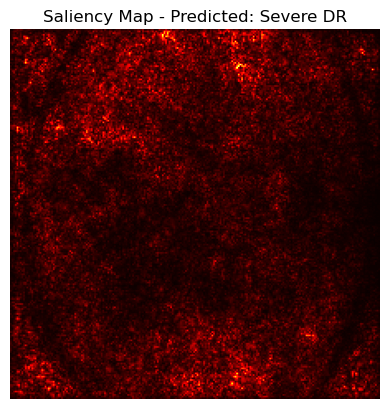

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import numpy as np

# Paths
data_dir = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy"
model_save_path = "vgg16_best_model.pth"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load entire dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes

# Split dataset into 80% train, 20% test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Load VGG16 model
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

# Modify classifier
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 5)
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training
best_val_loss = float('inf')
patience, counter = 5, 0
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(25):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

    avg_train_loss = train_loss / total
    avg_train_acc = correct.double() / total
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc.item())

    # Validation
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = correct.double() / len(test_loader.dataset)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc.item())

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_acc:.4f} | Val Loss={avg_val_loss:.4f}, Val Acc={avg_val_acc:.4f}")
    scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Plot Loss and Accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Classification Report
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Saliency Map Function
def show_saliency_map(model, image_tensor):
    image_tensor = image_tensor.unsqueeze(0).to(device).requires_grad_()
    model.eval()
    output = model(image_tensor)
    pred_class = output.argmax().item()
    output[0, pred_class].backward()
    saliency = image_tensor.grad.abs().squeeze().cpu().numpy()
    saliency = np.max(saliency, axis=0)
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')
    plt.title(f'Saliency Map - Predicted: {class_names[pred_class]}')
    plt.show()

# Predict on sample image
def predict_sample(img_path):
    img = Image.open(img_path).convert("RGB")
    tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    img_tensor = tf(img)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
        print(f"Predicted Class: {class_names[pred.item()]}")
    show_saliency_map(model, img_tensor)

# Test on sample image
predict_sample(r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Severe DR\Severe DR_5.png")


C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=1.0290, Acc=0.6155 | Val Loss=0.9528, Acc=0.6473
Epoch 2: Train Loss=0.8591, Acc=0.6723 | Val Loss=0.8316, Acc=0.6818
Epoch 3: Train Loss=0.8134, Acc=0.6809 | Val Loss=0.8120, Acc=0.6945
Epoch 4: Train Loss=0.7813, Acc=0.6836 | Val Loss=0.8466, Acc=0.6545
Epoch 5: Train Loss=0.7670, Acc=0.7082 | Val Loss=0.8344, Acc=0.6873
Epoch 6: Train Loss=0.7070, Acc=0.7214 | Val Loss=0.7786, Acc=0.7218
Epoch 7: Train Loss=0.6837, Acc=0.7345 | Val Loss=0.7100, Acc=0.7345
Epoch 8: Train Loss=0.6693, Acc=0.7405 | Val Loss=0.7216, Acc=0.7164
Epoch 9: Train Loss=0.6562, Acc=0.7441 | Val Loss=0.7443, Acc=0.7091
Epoch 10: Train Loss=0.6668, Acc=0.7423 | Val Loss=0.7224, Acc=0.7364
Epoch 11: Train Loss=0.6175, Acc=0.7714 | Val Loss=0.6868, Acc=0.7382
Epoch 12: Train Loss=0.6275, Acc=0.7614 | Val Loss=0.6867, Acc=0.7327
Epoch 13: Train Loss=0.5905, Acc=0.7700 | Val Loss=0.6966, Acc=0.7364
Epoch 14: Train Loss=0.5895, Acc=0.7668 | Val Loss=0.7016, Acc=0.7291
Epoch 15: Train Loss=0.5940, 

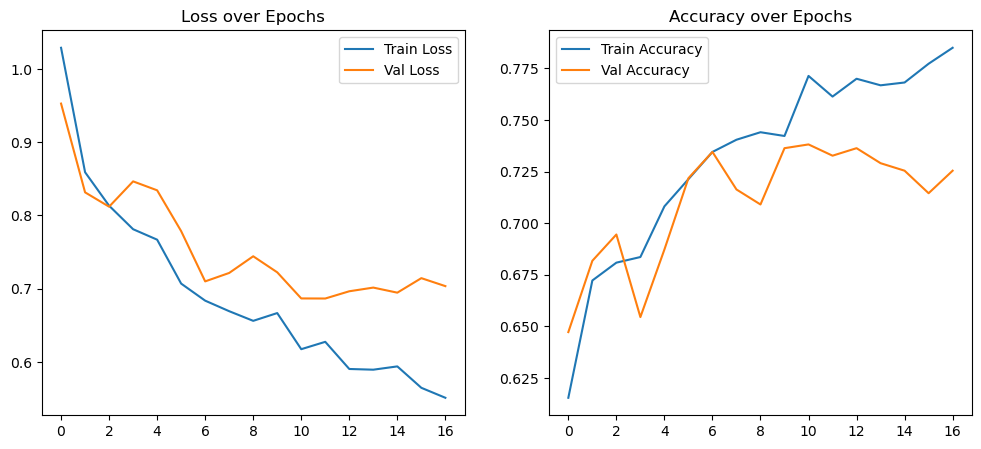


Classification Report:
                precision    recall  f1-score   support

       Healthy       0.94      0.97      0.95       199
       Mild DR       0.67      0.62      0.64        73
   Moderate DR       0.67      0.81      0.73       186
Proliferate DR       0.43      0.18      0.26        55
     Severe DR       0.44      0.32      0.38        37

      accuracy                           0.75       550
     macro avg       0.63      0.58      0.59       550
  weighted avg       0.73      0.75      0.73       550



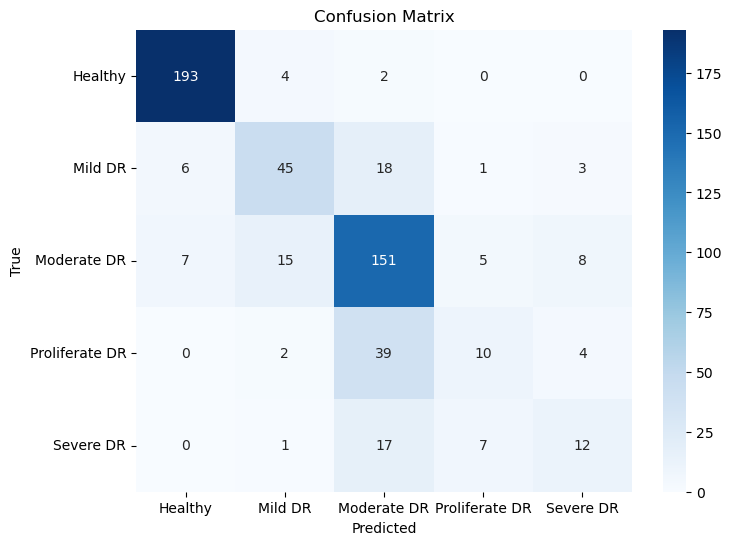

Predicted Class: Severe DR


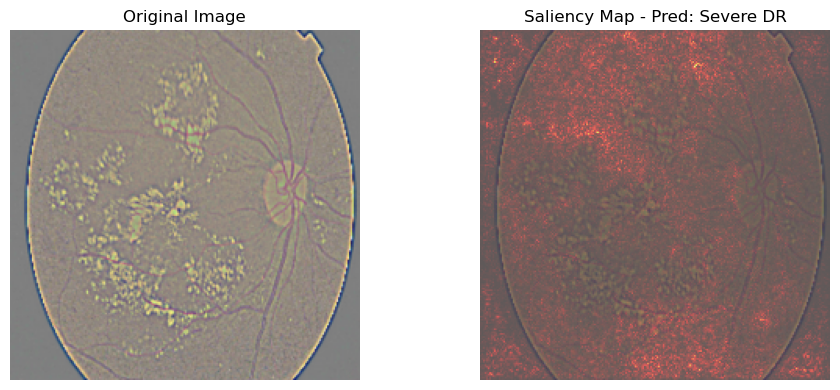

In [2]:
#good model with good accuracy

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import numpy as np

# Paths
data_dir = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy"
model_save_path = "vgg16_best_model.pth"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load and split dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Use a smaller batch size for memory efficiency
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load and modify VGG16
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 5)
)
model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training
EPOCHS = 25
best_val_loss = float('inf')
patience = 5
counter = 0
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

    avg_train_loss = train_loss / total
    avg_train_acc = correct.double() / total
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc.item())

    # Validation
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = correct.double() / len(test_loader.dataset)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc.item())

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Acc={avg_train_acc:.4f} | Val Loss={avg_val_loss:.4f}, Acc={avg_val_acc:.4f}")
    scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Val Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Evaluation
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Saliency Map
def show_saliency_map(model, image_tensor, class_names):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    image_tensor.requires_grad = True

    model.eval()
    output = model(image_tensor)
    pred_class = output.argmax().item()
    output[0, pred_class].backward()

    saliency = image_tensor.grad.data.abs().squeeze().cpu()
    saliency, _ = torch.max(saliency, dim=0)

    # Normalize saliency
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

    # Show original + saliency
    img = image_tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img, alpha=0.6)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.title(f"Saliency Map - Pred: {class_names[pred_class]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict a sample image
def predict_sample(img_path):
    img = Image.open(img_path).convert("RGB")
    tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    img_tensor = tf(img)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
        print(f"Predicted Class: {class_names[pred.item()]}")
    show_saliency_map(model, img_tensor, class_names)

# ✅ Test on a sample image
predict_sample(r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Severe DR\Severe DR_5.png")


Predicted Class: Proliferate DR


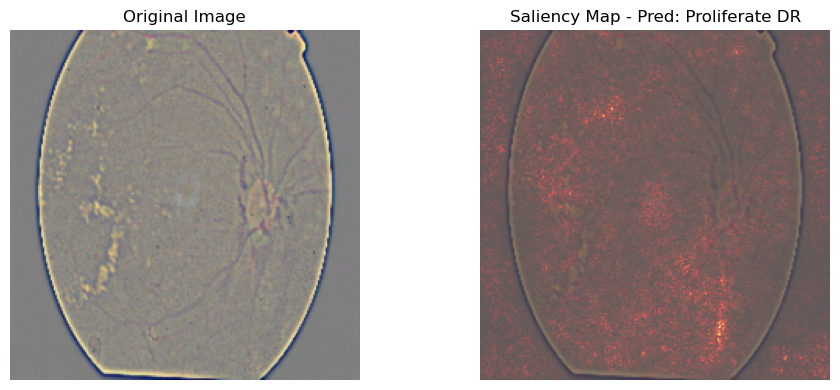

In [3]:
# ✅ Test on a sample image
predict_sample(r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Proliferate DR\Proliferate DR_8.png")

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Epoch 1: Train Loss=1.2639, Acc=0.4336 | Val Loss=1.2302, Acc=0.4582
Epoch 2: Train Loss=1.1223, Acc=0.4745 | Val Loss=1.0966, Acc=0.5273
Epoch 3: Train Loss=0.9685, Acc=0.5532 | Val Loss=1.1915, Acc=0.5255
Epoch 4: Train Loss=0.9401, Acc=0.5618 | Val Loss=1.0446, Acc=0.5345
Epoch 5: Train Loss=0.9070, Acc=0.5705 | Val Loss=1.0711, Acc=0.5418
Epoch 6: Train Loss=0.8314, Acc=0.6145 | Val Loss=0.9304, Acc=0.6364
Epoch 7: Train Loss=0.8231, Acc=0.6245 | Val Loss=0.9600, Acc=0.6018
Epoch 8: Train Loss=0.7693, Acc=0.6300 | Val Loss=1.0252, Acc=0.5455
Epoch 9: Train Loss=0.7511, Acc=0.6423 | Val Loss=1.0032, Acc=0.5891
Epoch 10: Train Loss=0.7428, Acc=0.6509 | Val Loss=1.0083, Acc=0.5727
Epoch 11: Train Loss=0.7148, Acc=0.6609 | Val Loss=0.9620, Acc=0.5927
Early stop

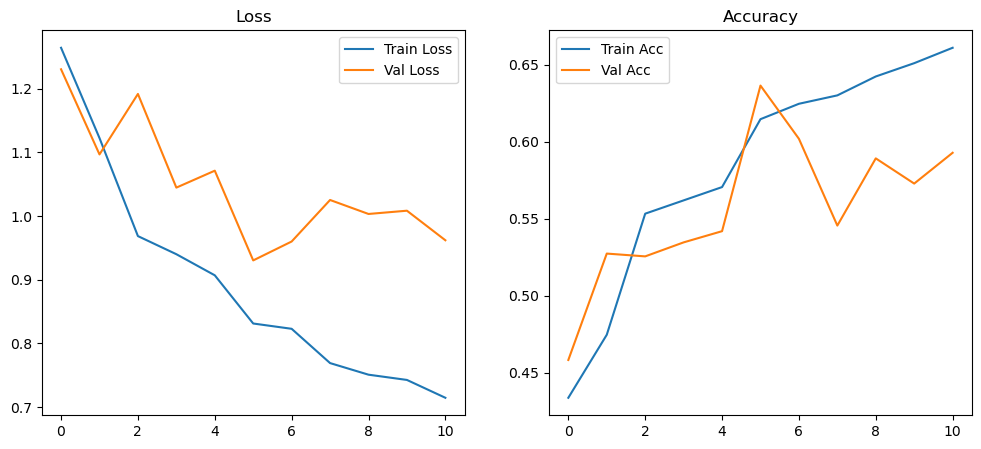

                precision    recall  f1-score   support

       Healthy       0.90      0.96      0.93       201
       Mild DR       0.51      0.71      0.59        78
   Moderate DR       0.67      0.21      0.32       171
Proliferate DR       0.26      0.35      0.30        54
     Severe DR       0.32      0.72      0.44        46

      accuracy                           0.61       550
     macro avg       0.53      0.59      0.52       550
  weighted avg       0.66      0.61      0.59       550



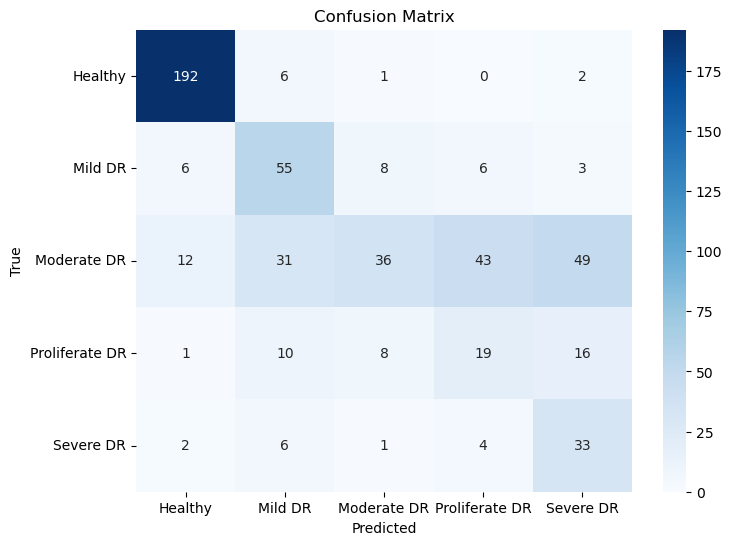

IndexError: list index out of range

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from PIL import Image

!pip install opencv-python

import cv2

# ========== CONFIGURATION ==========
data_dir = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy"
model_save_path = "vgg16_best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
EPOCHS = 25

# ========== TRANSFORMS ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ========== LOAD DATA ==========
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# ========== CLASS WEIGHTING ==========
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
class_weights = [1.0 / class_counts[t] for t in targets]
sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ========== MODEL ==========
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 5)
)
model = model.to(device)

# ========== LOSS AND OPTIMIZER ==========
weight_tensor = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))]).float().to(device)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ========== TRAINING LOOP ==========
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
best_val_loss, counter, patience = float("inf"), 0, 5

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

    avg_train_loss = total_loss / total
    avg_train_acc = correct.double() / total
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc.item())

    # Validation
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = correct.double() / len(test_loader.dataset)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc.item())

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Acc={avg_train_acc:.4f} | Val Loss={avg_val_loss:.4f}, Acc={avg_val_acc:.4f}")
    scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# ========== PLOTS ==========
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# ========== EVALUATION ==========
model.load_state_dict(torch.load(model_save_path))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ========== GRAD-CAM ==========
def generate_gradcam(model, image_tensor, target_class, target_layer):
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Hook the gradients and activations
    gradients, activations = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_backward_hook(backward_hook)

    model.eval()
    output = model(image_tensor)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    grads = gradients[0].detach()
    acts = activations[0].detach()
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])

    for i in range(acts.shape[1]):
        acts[0, i, :, :] *= pooled_grads[i]

    heatmap = acts.squeeze().sum(dim=0).cpu()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.numpy()

    handle_fw.remove()
    handle_bw.remove()
    return heatmap

# Visualize Grad-CAM on a few test images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

sample_images = []
sample_labels = []

for inputs, labels in test_loader:
    sample_images.extend(inputs)
    sample_labels.extend(labels)
    if len(sample_images) >= 3:
        break

for i in range(3):
    img_tensor = sample_images[i]
    true_label = sample_labels[i].item()
    heatmap = generate_gradcam(model, img_tensor, true_label, model.features[-1])

    # Convert tensor to image
    img_np = inv_normalize(img_tensor).permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    # Resize heatmap
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = np.uint8(255 * img_np)
    superimposed_img = cv2.addWeighted(superimposed_img, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original - {class_names[true_label]}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.3785625].


IndexError: list index out of range

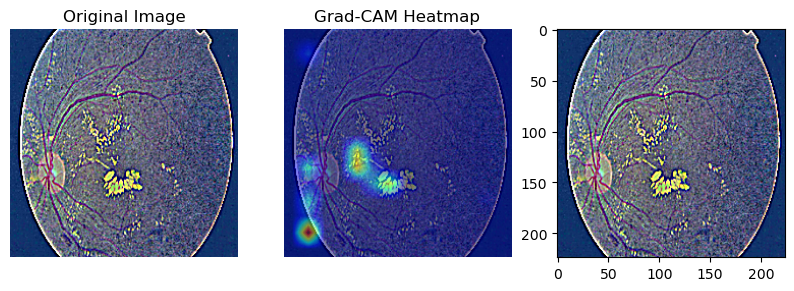

In [19]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Function to load and preprocess the image
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Function to get the class labels (adjust this based on your dataset)
class_labels = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferative DR', 'Severe DR']

# Load the model
model = models.vgg16(pretrained=True)
model.eval()

# Function to generate Grad-CAM heatmap
def generate_gradcam(model, image_tensor, target_class, target_layer):
    # Ensure the model is on the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    image_tensor = image_tensor.to(device)

    # Hook to extract features from the target layer
    def save_gradient(module, grad_input, grad_output):
        global gradient
        gradient = grad_output[0]  # We need the gradient of the output

    # Hook to save the output of the target layer
    def save_activation(module, input, output):
        global activation
        activation = output

    target_layer = model.features[28]  # Select the target layer (e.g., last convolutional layer)
    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)

    # Forward pass
    output = model(image_tensor)

    # Backward pass to get gradients
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    # Generate Grad-CAM
    weights = torch.mean(gradient, dim=(2, 3), keepdim=True)
    gradcam = torch.sum(weights * activation, dim=1, keepdim=True)
    gradcam = torch.relu(gradcam)
    gradcam = gradcam.squeeze().cpu().detach().numpy()

    # Normalize the heatmap
    gradcam = cv2.resize(gradcam, (224, 224))
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())

    return gradcam, output

# Function to visualize the original image, Grad-CAM, and model prediction
def visualize_gradcam(img_tensor, gradcam, output, class_labels):
    img = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array

    # Display the original image
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Display Grad-CAM heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.imshow(gradcam, cmap='jet', alpha=0.5)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    # Display predicted class
    predicted_class = torch.argmax(output, dim=1).item()
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.title(f'Predicted: {class_labels[predicted_class]}')
    plt.axis('off')

    plt.show()

# Sample image path
image_path = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Severe DR\Severe DR_29.png"  # Replace with your image path
img_tensor = load_image(image_path)

# Specify the class label for Grad-CAM (you can experiment with different classes)
true_label = 0  # Replace with the actual class for your image

# Generate Grad-CAM heatmap and output
heatmap, output = generate_gradcam(model, img_tensor, true_label, target_layer=28)  # Target layer index (adjust if needed)

# Visualize Grad-CAM along with the original image and predicted class
visualize_gradcam(img_tensor, heatmap, output, class_labels)

# Check the model's output shape
output = model(image_tensor)
print(f"Output shape: {output.shape}")

# Ensure your class_labels list matches the model's output
class_labels = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferative DR', 'Severe DR']

# Predict the class and check if it's within the range of the class_labels list
predicted_class = torch.argmax(output, dim=1).item()

# Ensure the predicted class is within bounds of the class_labels list
if predicted_class < len(class_labels):
    plt.title(f'Predicted: {class_labels[predicted_class]}')
else:
    plt.title('Predicted: Class Index Out of Range')



In [23]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import os

# Load model (assume it's already trained and saved)
model = torch.load(r"C:\Users\vishal kumar\vgg16_diabetic_retinopathy_model.pth", map_location=torch.device('cpu'))
model.eval()

# Define class labels
class_labels = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferative DR', 'Severe DR']

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
img_path = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Severe DR\Severe DR_29.png"  # Change to your image path
img = Image.open(img_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0)  # Shape: (1, 3, 224, 224)
img_tensor.requires_grad = True

# Grad-CAM implementation
def generate_gradcam(model, image_tensor, target_class, target_layer_idx):
    activations = []
    gradients = []

    def save_activation(module, input, output):
        activations.append(output)

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Hook target layer
    target_layer = list(model.features.children())[target_layer_idx]
    forward_hook = target_layer.register_forward_hook(save_activation)
    backward_hook = target_layer.register_full_backward_hook(save_gradient)

    # Forward
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()
    print(f"Predicted class index: {pred_class} | Label: {class_labels[pred_class]}")

    # Backward
    model.zero_grad()
    class_loss = output[0, pred_class]
    class_loss.backward()

    # Remove hooks
    forward_hook.remove()
    backward_hook.remove()

    # Get hooked data
    activation = activations[0].detach()
    gradient = gradients[0].detach()

    weights = torch.mean(gradient, dim=(2, 3), keepdim=True)
    gradcam_map = torch.sum(weights * activation, dim=1).squeeze()

    # Normalize heatmap
    gradcam_map = torch.clamp(gradcam_map, min=0)
    gradcam_map -= gradcam_map.min()
    gradcam_map /= gradcam_map.max()
    return gradcam_map.cpu().numpy(), output

# Grad-CAM visualization function
def visualize_gradcam(img_tensor, gradcam_map, output, class_labels):
    pred_class = output.argmax(dim=1).item()
    predicted_label = class_labels[pred_class] if pred_class < len(class_labels) else "Unknown"

    # Convert tensor image to numpy
    img_np = img_tensor.squeeze().detach().cpu().numpy()
    img_np = np.transpose(img_np, (1, 2, 0))  # CHW -> HWC
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    img_np = np.clip(img_np, 0, 1)

    # Resize Grad-CAM to match image
    heatmap = cv2.resize(gradcam_map, (img_np.shape[1], img_np.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img_rgb = np.uint8(255 * img_np)
    overlay = cv2.addWeighted(img_rgb, 0.6, heatmap_color, 0.4, 0)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_color[..., ::-1])  # Convert BGR to RGB
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate Grad-CAM and visualize
gradcam_map, output = generate_gradcam(model, img_tensor, target_class=None, target_layer_idx=28)  # VGG16's last conv layer
visualize_gradcam(img_tensor, gradcam_map, output, class_labels)


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'